## Imports

In [5]:
% matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [6]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [3]:
path = Path('data', 'bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]]).strip()
    doc_list.append([topic, heading, body])

### Convert to DataFrame

In [4]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
body       2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


### Inspect results

In [5]:
docs.sample(10)

,topic,heading,body
223,tech,Apple laptop is 'greatest gadget',The Apple Powerbook 100 has been chosen as the...
1370,business,Venezuela and China sign oil deal,Venezuelan president Hugo Chavez has offered C...
1822,business,South African car demand surges,"Car manufacturers with plants in South Africa,..."
537,sport,London Irish 19-33 Wasps,Wasps made light of the absence of several int...
144,tech,Microsoft makes anti-piracy move,Microsoft says it is clamping down on people r...
565,sport,Wenger dejected as Arsenal slump,Arsenal manager Arsene Wenger claimed their di...
103,tech,DVD copy protection strengthened,DVDs will be harder to copy thanks to new anti...
1610,business,Oil prices reach three-month low,Oil prices have fallen heavily for a second da...
1742,business,UK Coal plunges into deeper loss,Shares in UK Coal have fallen after the mining...
2218,entertainment,Ray DVD beats box office takings,Oscar-nominated film biopic Ray has surpassed ...


### Data drawn from 5 different categories

In [6]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


## Explore Corpus

### Token Count via Counter()

In [7]:
# word count
word_count = docs.body.str.split().str.len().sum()
print(f'Total word count: {word_count:,d} | per article: {word_count/len(docs):,.0f}')

Total word count: 842,910 | per article: 379


In [8]:
token_count = Counter()
for i, doc in enumerate(docs.body.tolist(), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split()])

500 1000 1500 2000 

In [9]:
tokens = (pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
          .set_index('token')
          .squeeze())

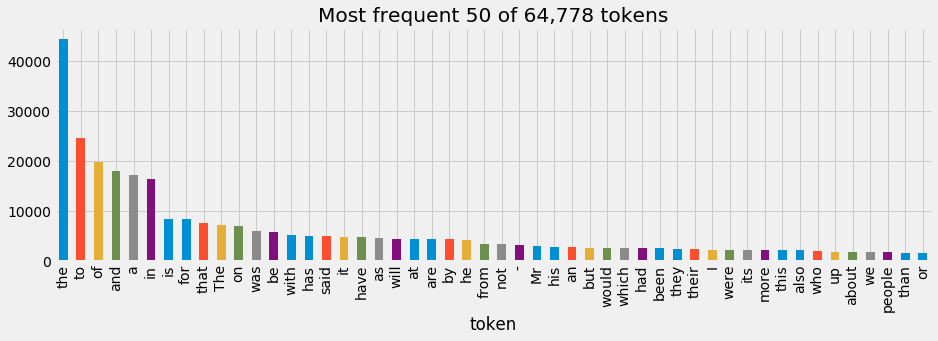

In [10]:
n = 50
(tokens
 .iloc[:50]
 .plot
 .bar(figsize=(14, 4), title=f'Most frequent {n} of {len(tokens):,d} tokens'));

## Document-Term Matrix with `CountVectorizer`

### Key parameters

In [11]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding

### Document Frequency Distribution

In [11]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                                    min_df=1,
                                    binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.body)

In [12]:
binary_dtm

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [13]:
n_docs, n_tokens = binary_dtm.shape

In [14]:
tokens_dtm = binary_vectorizer.get_feature_names()

#### CountVectorizer skips certain tokens by default

In [15]:
tokens.index.difference(pd.Index(tokens_dtm))

Index(['!', '"', '""unconscionable,', '"'I', '"'Oh', '"'We', '"'You', '"(When',
       '"...it', '"100%',
       ...
       'Â£900m', 'Â£910m).', 'Â£93.6bn)', 'Â£933m', 'Â£947m', 'Â£960m',
       'Â£98)', 'Â£99', 'Â£9m', 'Â£9m,'],
      dtype='object', length=47927)

#### Persist Result

In [17]:
dtm_path = Path('data/binary_dtm.npz')
if not dtm_path.exists():
    sparse.save_npz(dtm_path, binary_dtm)
else:
    binary_dtm = sparse.load_npz(dtm_path)

In [18]:
token_path = Path('data/tokens.csv')
if not token_path.exists():
    pd.Series(tokens_dtm).to_csv(token_path, index=False)
else:
    tokens = pd.read_csv(token_path, header=None, squeeze=True)

In [19]:
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(n_docs)
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [20]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
    axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

### Most similar documents

In [84]:
m = binary_dtm.todense()
pairwise_distances = pdist(m, metric='cosine')

In [86]:
closest = np.argmin(pairwise_distances)

In [91]:
rows, cols = np.triu_indices(n_docs)
rows[closest], cols[closest]

(11, 75)

In [125]:
docs.iloc[11].to_frame(11).join(docs.iloc[75].to_frame(75)).to_csv('data/most_similar.csv')

In [113]:
docs.iloc[75]

topic                                                   tech
heading                     BT program to beat dialler scams
body        BT is introducing two initiatives to help bea...
Name: 75, dtype: object

In [114]:
pd.DataFrame(binary_dtm[[11,75], :].todense()).sum(0).value_counts()

0    28873
1      344
2       58
dtype: int64

### Baseline document-term matrix

In [21]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [22]:
doc_term_matrix.shape

(2225, 29275)

### Inspect tokens

In [23]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

### Inspect doc-term matrix

In [24]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Most frequent terms

In [25]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int64

### Compute relative term frequency

In [27]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 29275)

In [28]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the    1.00
to     1.00
of     0.99
and    0.99
in     0.99
for    0.93
on     0.91
is     0.86
it     0.86
said   0.85
dtype: float64

### Visualize Doc-Term Matrix

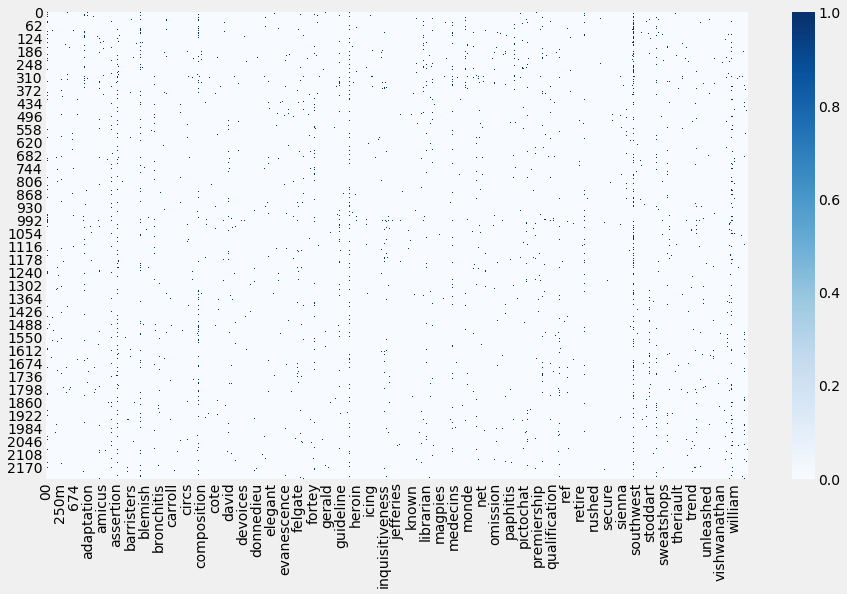

In [29]:
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

### Using thresholds to reduce the number of tokens 

In [42]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 12789)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [ ]:
nlp = spacy.load('en')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [ ]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

In [ ]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

## Document-Term Matrix with `TfIDFVectorizer`

### Key Parameters

The `TfIDFTransformer` builds on the `CountVectorizer` output; the `TfIDFVectorizer` integrates both

In [43]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf of term t is
    tf-idf(d, t) = tf(t) * idf(d, t), and the idf is computed as
    idf(d, t) = log [ n / df(d, t) ] + 1 (if ``smooth_idf=False``),
    where n is the total number of documents and df(d, t) is the
    document frequency; the document frequency is the number of documents d
    that contain term t. The effect of addi

### How Term Frequency - Inverse Document Frequency works

In [7]:
sample_docs = ['call you tomorrow', 
                'Call me a taxi', 
                'please call me... PLEASE!']

#### Compute term frequency

In [8]:
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs).todense()
tokens = vectorizer.get_feature_names()

In [9]:
term_frequency = pd.DataFrame(data=tf_dtm, 
                              columns=tokens)
print(term_frequency)

   call  me  please  taxi  tomorrow  you
0     1   0       0     0         1    1
1     1   1       0     1         0    0
2     1   1       2     0         0    0


#### Compute document frequency

In [10]:
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense().sum(axis=0)

In [12]:
document_frequency = pd.DataFrame(data=df_dtm,
                                  columns=tokens)
print(document_frequency)

   call  me  please  taxi  tomorrow  you
0     3   2       1     1         1    1


#### Compute TfIDF

In [13]:
tfidf = pd.DataFrame(data=tf_dtm/df_dtm, columns=tokens)
print(tfidf)

   call   me  please  taxi  tomorrow  you
0  0.33 0.00    0.00  0.00      1.00 1.00
1  0.33 0.50    0.00  1.00      0.00 0.00
2  0.33 0.50    2.00  0.00      0.00 0.00


#### The effect of smoothing

The TfidfVectorizer uses smoothing for document and term frequencies:
- `smooth_idf`: add one to document frequency, as if an extra document contained every token in the vocabulary
     once to prevents zero divisions
- `sublinear_tf`: scale term Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)

In [14]:
vect = TfidfVectorizer(smooth_idf=True, 
                       norm='l2',            # squared weights sum to 1 by document
                       sublinear_tf=False,   # if True, use 1+log(tf)
                       binary=False)
print(pd.DataFrame(vect.fit_transform(sample_docs).todense(), 
             columns=vect.get_feature_names()))

   call   me  please  taxi  tomorrow  you
0  0.39 0.00    0.00  0.00      0.65 0.65
1  0.43 0.55    0.00  0.72      0.00 0.00
2  0.27 0.34    0.90  0.00      0.00 0.00


### TfIDF with new articles

In [126]:
tfidf = TfidfVectorizer(stop_words='english')
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens = tfidf.get_feature_names()
dtm_tfidf.shape

(2225, 28980)

In [127]:
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1,
                            'token': tokens})
              .sort_values('tfidf', ascending=False))

In [128]:
token_freq.head(10).append(token_freq.tail(10)).set_index('token')

,tfidf
token,
said,87.25
mr,58.22
year,41.98
people,37.30
new,34.20
film,29.73
government,28.79
world,27.03
time,26.36


### Summarizing news articles using TfIDF weights

#### Select random article

In [140]:
article = docs.sample(1).squeeze()
article_id = article.name

In [141]:
print(f'Topic:\t{article.topic.capitalize()}\n\n{article.heading}\n')
print(article.body.strip())

Topic:	Politics

MPs issued with Blackberry threat

MPs will be thrown out of the Commons if they use Blackberries in the chamber Speaker Michael Martin has ruled.  The Â£200 handheld computers can be used as a phone, pager or to send e-mails. The devices gained new prominence this week after Alastair Campbell used his to accidentally send an expletive-laden message to a Newsnight journalist. Mr Martin revealed some MPs had been using their Blackberries during debates and he also cautioned members against using hidden earpieces.  The use of electronic devices in the Commons chamber has long been frowned on. The sound of a mobile phone or a pager can result in a strong rebuke from either the Speaker or his deputies. The Speaker chairs debates in the Commons and is charged with ensuring order in the chamber and enforcing rules and conventions of the House. He or she is always an MP chosen by colleagues who, once nominated, gives up all party political allegiances.


#### Select most relevant tokens by tfidf value

In [142]:
article_tfidf = dtm[article_id].todense().A1
article_tokens = pd.Series(article_tfidf, index=tokens)
article_tokens.sort_values(ascending=False).head(10)

speaker        0.33
chamber        0.31
blackberries   0.27
pager          0.26
debates        0.23
commons        0.22
send           0.15
devices        0.15
mps            0.15
martin         0.14
dtype: float64

#### Compare to random selection

In [144]:
pd.Series(article.body.split()).sample(10).tolist()

['Campbell',
 'after',
 'in',
 'deputies.',
 'as',
 'strong',
 'using',
 'Speaker',
 'either',
 'be']

## Create Train & Test Sets

### Stratified `train_test_split`

In [34]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [35]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [36]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
entertainment     9
tech              9
politics          9
Name: topic, dtype: int64

### Vectorize train & test sets

In [38]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.body)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178572 stored elements in Compressed Sparse Row format>

In [40]:
test_dtm = vectorizer.transform(test_docs.body)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4160 stored elements in Compressed Sparse Row format>